# How To Use Imagix
Imagix is our implementation of a variational autoencoder for image data.  
This tutorial follows the structure of `Getting Started - Vanillix`, but is much less extensive because our pipeline works similarly across different architectures. Here we focus only on Imagix specifics.

**AUTOENCODIX** supports far more functionality than shown here, so we’ll also point to advanced tutorials where relevant.  

**IMPORTANT**

> This tutorial only shows the specifics of the Imagix pipeline. If you're unfamiliar with general concepts,  
> we recommend following the `Getting Started - Vanillix` Tutorial first.

## What You'll Learn

You’ll learn how to:

1. **Initialize** the pipeline and run it. <br><br>
2. Understand the Imagix specific **pipeline steps**. <br><br>
3. Access the Imagix specific **results** (mus, sigma, kl/mmd losses). <br><br>
4. **Visualize** outputs effectively. <br><br>
5. Apply **custom parameters**. <br><br>
6. **Save, load, and reuse** a trained pipeline. <br><br>


**Setting the Correct Path**

In [1]:
import os

p = os.getcwd()
d = "autoencodix_package"
if d not in p:
    raise FileNotFoundError(f"'{d}' not found in path: {p}")
os.chdir(os.sep.join(p.split(os.sep)[: p.split(os.sep).index(d) + 1]))
print(f"Changed to: {os.getcwd()}")


Changed to: /home/ewald/Github/autoencodix_package


## 1) Initialize the Imagix Pipeline
`Imagix` is a standard VAE implementation for image data. We don't allow different data modalities for `Imagix`.  
To run the pipeline we need to prepare two things:  

1. A directory with image files. We allow the following extensions: `".jpg", ".jpeg", ".png", ".tif", ".tiff"` (NOT case sensitive).<br><br>
2. An annotation file with metadata, where we map `sample_ids` to image paths. For this, we need to provide the name of the column where the image path information is stored. This is done via the `img_paths_col` config parameter.

#### 1.1 The Dataset
Here we use a series of C. elegans images during embryogenesis. The images are taken at different time points during development. We provide metadata about the time point during embryogenesis and an indicator if this time point was early or not.  

**A Look Inside the Annotation File**:


In [2]:
import os
import pandas as pd
import autoencodix as acx
from autoencodix.configs.default_config import (
    DefaultConfig,
    DataConfig,
    DataCase,
    DataInfo,
)

IMGROOT = os.path.join("data/images/ALY-2_SYS721/")
IMGMAPPING = os.path.join("data/ALY-2_SYS721_mappings.txt")
anno_df = pd.read_csv(IMGMAPPING, sep="\t", index_col=0)
anno_df.head()

,img_paths,extra_class_labels,early
sample_ids,,,
T_1,ALY-2_SYS721_t1.tif,1,'1'
T_2,ALY-2_SYS721_t2.tif,2,'1'
T_3,ALY-2_SYS721_t3.tif,3,'1'
T_4,ALY-2_SYS721_t4.tif,4,'1'
T_5,ALY-2_SYS721_t5.tif,5,'1'


**Define Config and Run Pipeline**

In [3]:
imgconfig = DefaultConfig(
    data_case=DataCase.IMG_TO_IMG,
    checkpoint_interval=10,
    epochs=250,
    reconstruction_loss="bce",
    beta=0.005,
    scaling="MINMAX",
    anneal_function="logistic-late",
    data_config=DataConfig(
        data_info={
            "IMG": DataInfo(
                file_path=IMGROOT,
                scaling="MINMAX",
                data_type="IMG",
            ),
            "ANNO": DataInfo(
                file_path=IMGMAPPING,
                data_type="ANNOTATION",
            ),
        },
    ),
)

imagix = acx.Imagix(config=imgconfig)
result = imagix.run()
backup_datset = result.datasets

Given image size is possible, rescaling images to: 64x64
Successfully loaded 260 images for IMG
calling normalize image in _process_ing_to_img_case
anno key: IMG
Converting 182 images to torch.float32 tensors...
Converting 52 images to torch.float32 tensors...
Converting 26 images to torch.float32 tensors...
Epoch 1 - Train Loss: 2852.7151
Sub-losses: recon_loss: 2852.6525, var_loss: 0.0626, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 2808.5763
Sub-losses: recon_loss: 2808.5763, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 2536.9056
Sub-losses: recon_loss: 2536.7227, var_loss: 0.1828, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Valid Loss: 2696.3299
Sub-losses: recon_loss: 2696.3299, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 3 - Train Loss: 2348.2598
Sub-losses: recon_loss: 2348.0509, var_loss: 0.2089, anneal_factor: 0.0000, effective_beta_factor: 0.0000


## 2) Understand Imagix Specific Steps
Since `Imagix` is jus a `Varix` for images, there are no extra steps for this pipeline.

## 3) Access Imagix Specific Results
The `result` object follows our standard interface. Refer to [1] for more details.  
We don't have any `Imagix` specific results, but you can directly visualize the reconstructions as images, as shown in the code below:

[1] Tutorials/DeepDives/PipelineOutputTutorial.ipynb


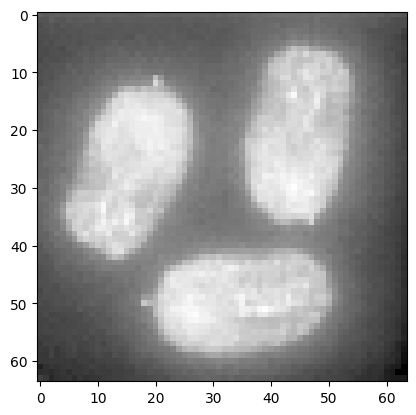

In [4]:
import matplotlib.pyplot as plt

sample_img = result.reconstructions.get(split="test", epoch=-1)
sample_img = sample_img[0, :, :, :]
sample_img = sample_img.squeeze()
sample_img.shape

plt.imshow(sample_img, cmap="grey")

## 4) Visualize Imagix Results
Since the results of `Imagix` are visually interpretable, we add an additional visualization:  
We show a grid of original images and reconstructed images with label information. See the code below for how to obtain this visualization.


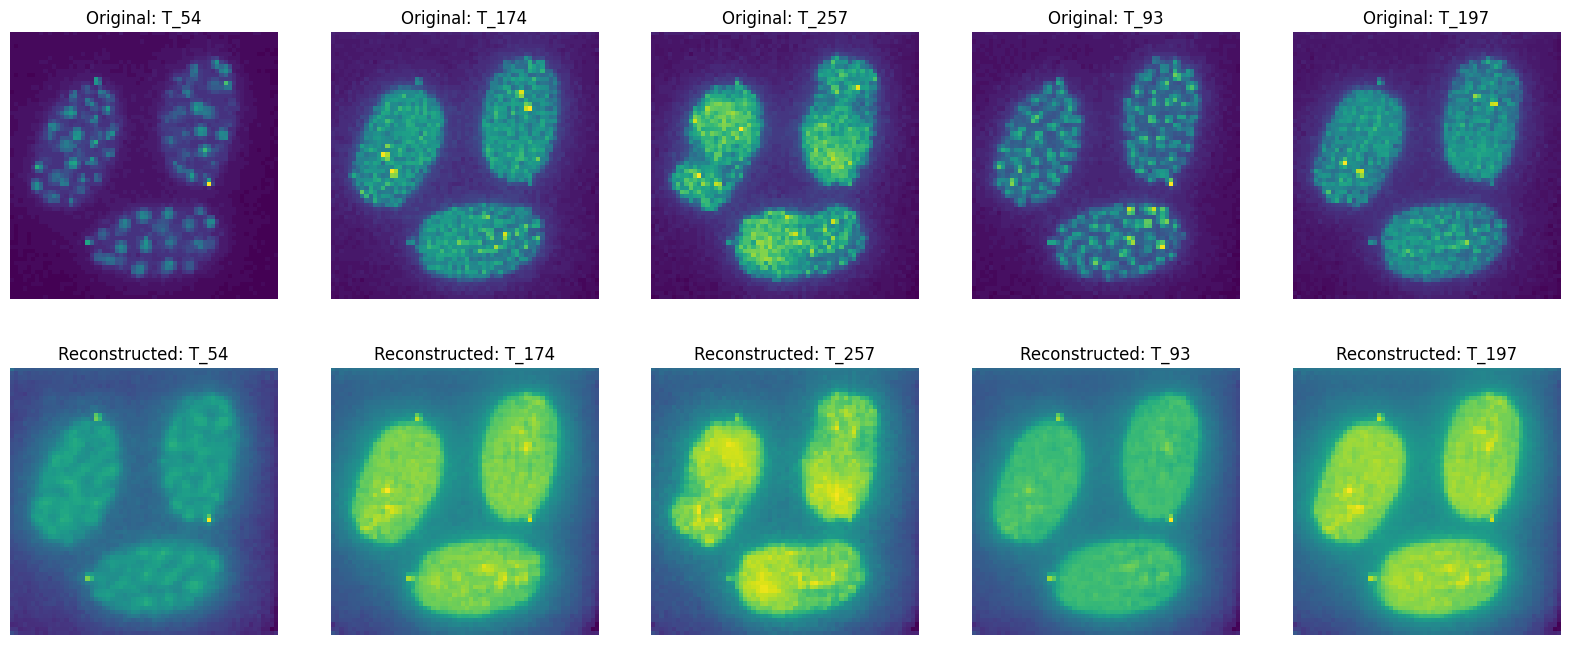

In [5]:
imagix.visualizer.show_image_recon_grid(result=imagix.result, n_samples=5)

**Standard Visualizations**  
We also offer the standard visualizations as for all other pipelines. You can pass one or more column names from the annotation data. These columns will be used to color the visualizations accordingly. In this example, we use the `early` parameter.


Creating plots ...


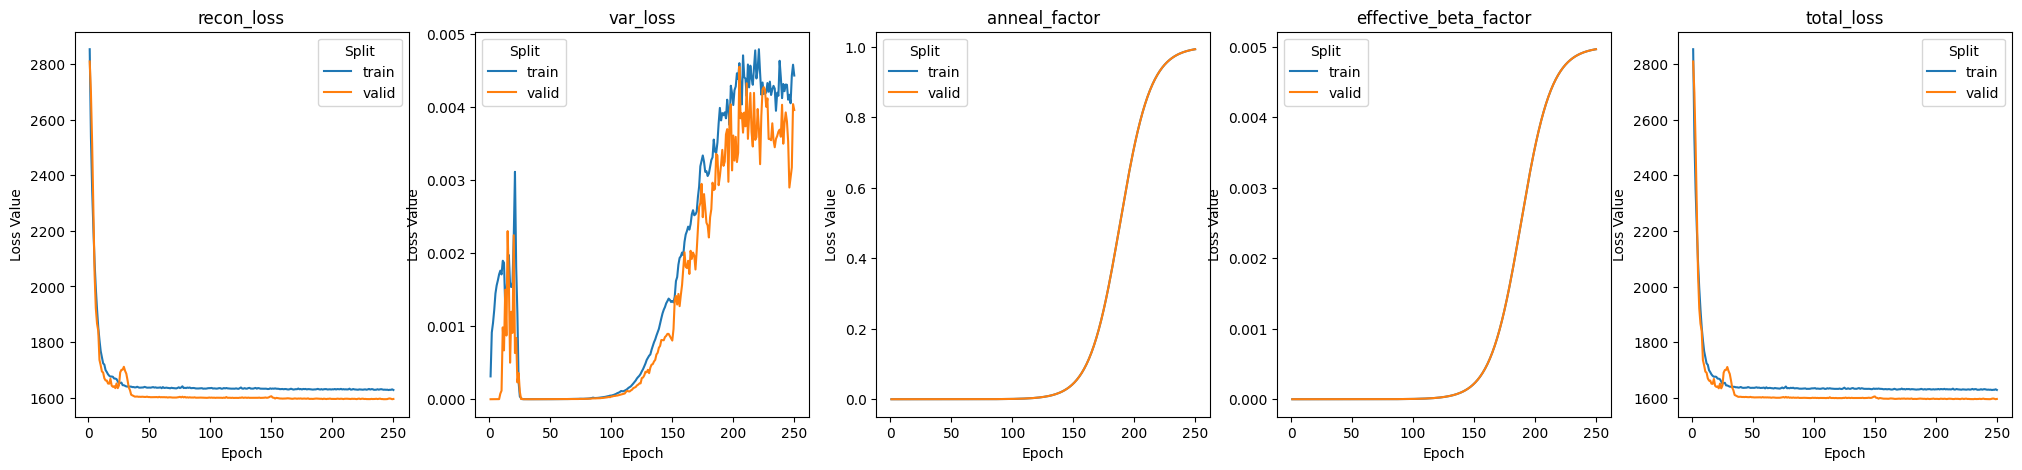

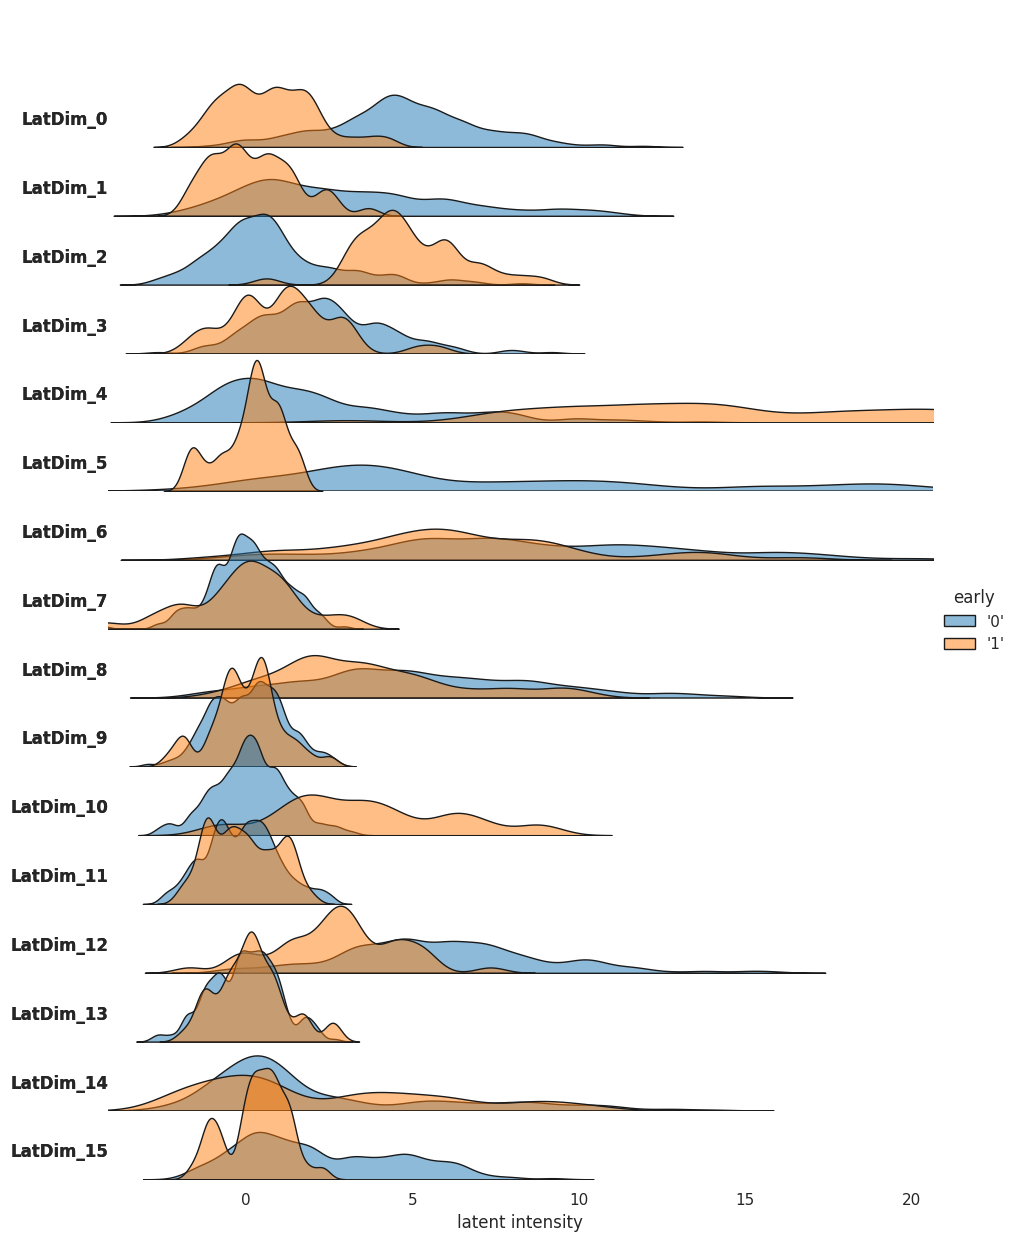

/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


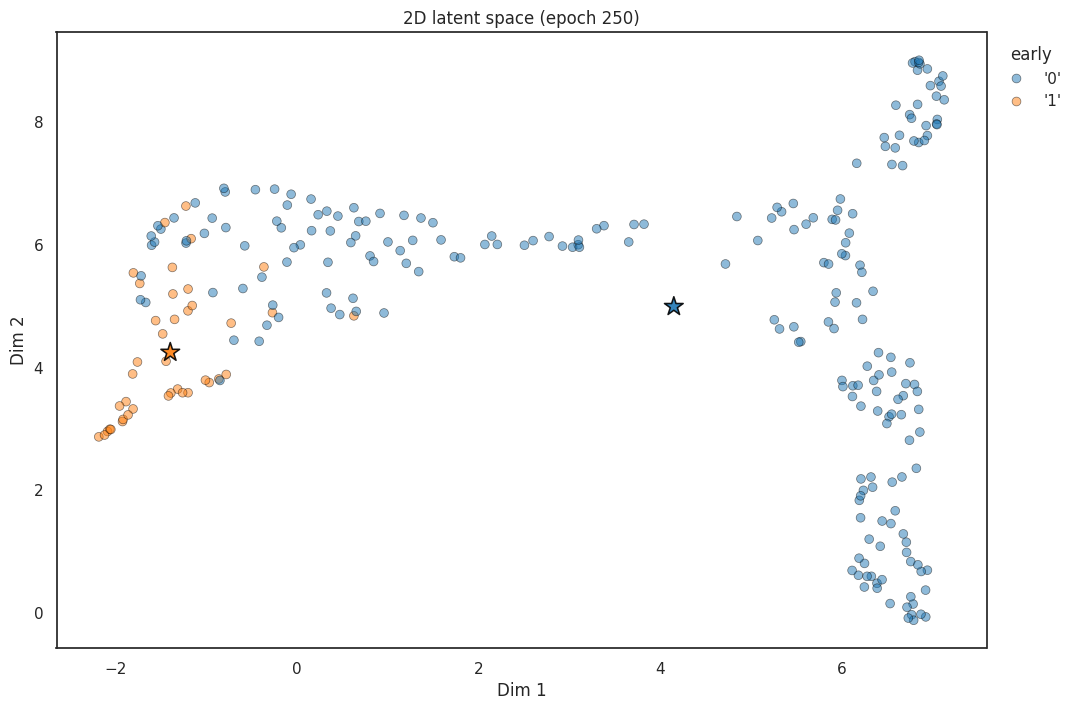

In [6]:
imagix.show_result(params=["early"])

## 5) Customize Imagix
Via the `Config` object we can apply customize the pipeline by chaning the `loss function` or the number of `epoch` or preprocessing. To get an full overview of the adjustable parameters, please refere to [2].

[2] Tutorials/DeepDives/ConfigTutorial.ipynb.

## 6) Load Save and Reuse Imagix
There are not `Imagix` specific steps here. See the `Getting Started - Vanillix` for details. Below is a basic save/load usecase.

In [7]:
import os
import glob

outpath = os.path.join("tutorial_res", "imagix.pkl")

imagix.save(file_path=outpath)

folder = os.path.dirname(outpath)
pkl_files = glob.glob(os.path.join(folder, "*imagix.pkl"))
model_files = glob.glob(os.path.join(folder, "*imagix.pth"))

print("PKL files:", pkl_files)
print("Model files:", model_files)

# the load functionality automatically will build the pipeline object out of the three saved files
imagix_loaded = acx.Imagix.load(outpath)

Preprocessor saved successfully.
saving memory efficient
Pipeline object saved successfully.
PKL files: []
Model files: []
Attempting to load a pipeline from tutorial_res/imagix.pkl.pkl...
Pipeline object loaded successfully. Actual type: Imagix
Preprocessor loaded successfully.


In [8]:
result_predict = imagix_loaded.predict(data=backup_datset)

Visualize on the new predictions.

Creating plots ...


/home/ewald/Github/autoencodix_package/src/autoencodix/base/_base_pipeline.py:993: UserWarning: No loss data found in results. Skipping loss curve visualization.
  warnings.warn(
/home/ewald/Github/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: tuple index out of range
  warnings.warn(
/home/ewald/Github/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: tuple index out of range
  warnings.warn(


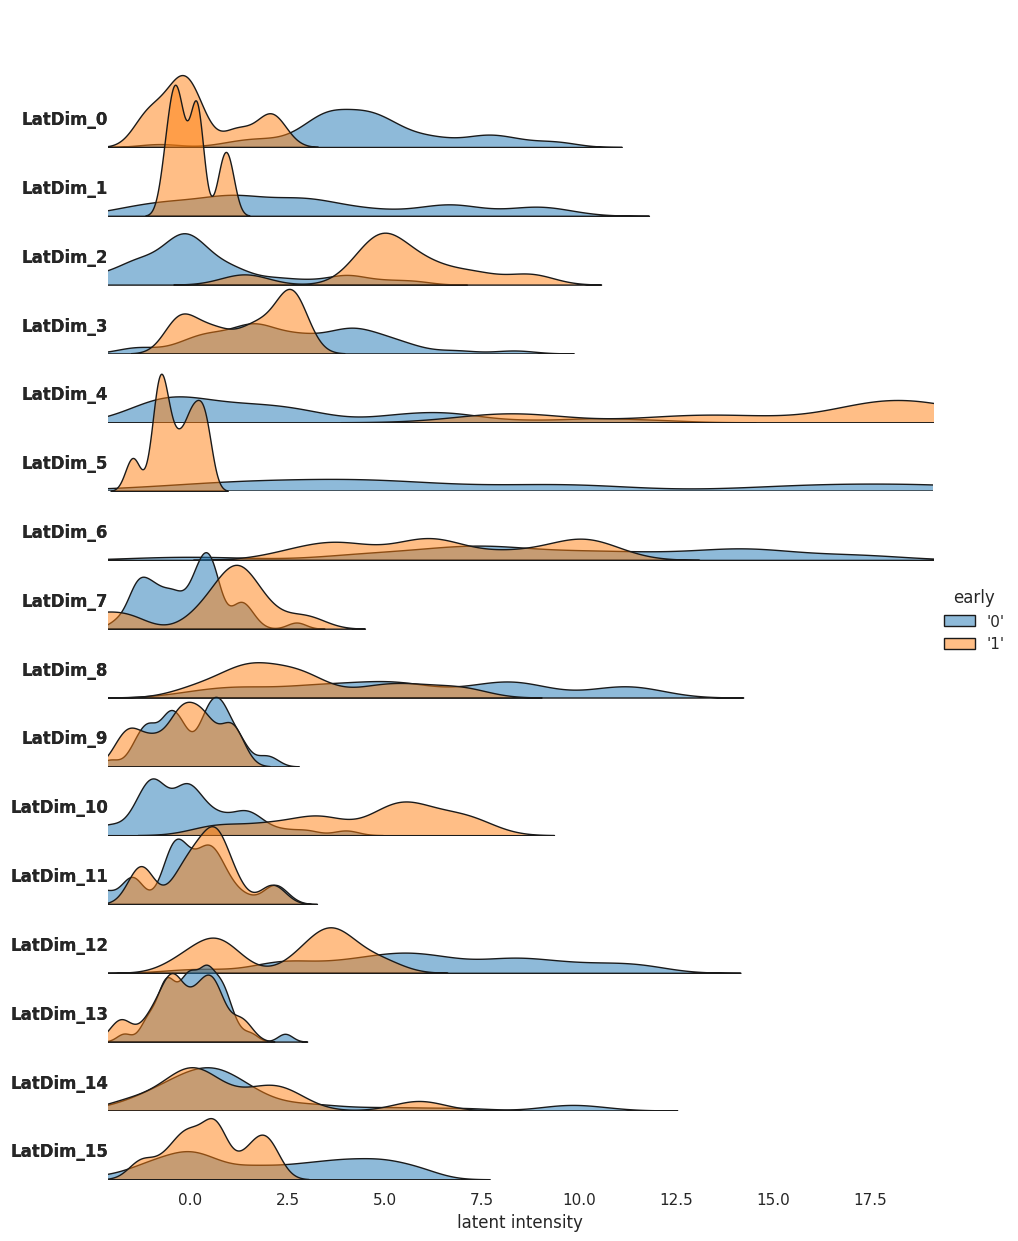

/home/ewald/Github/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: tuple index out of range
  warnings.warn(
/home/ewald/Github/autoencodix_package/src/autoencodix/utils/_result.py:346: UserWarning: We could not create visualizations for the loss plots.
This usually happens if you try to visualize after saving and loading the pipeline object with `save_all=False`. This memory-efficient saving mode does not retain past training loss data.

Original error message: tuple index out of range
  warnings.warn(
/home/ewald/Github/autoencodix_package/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be remo

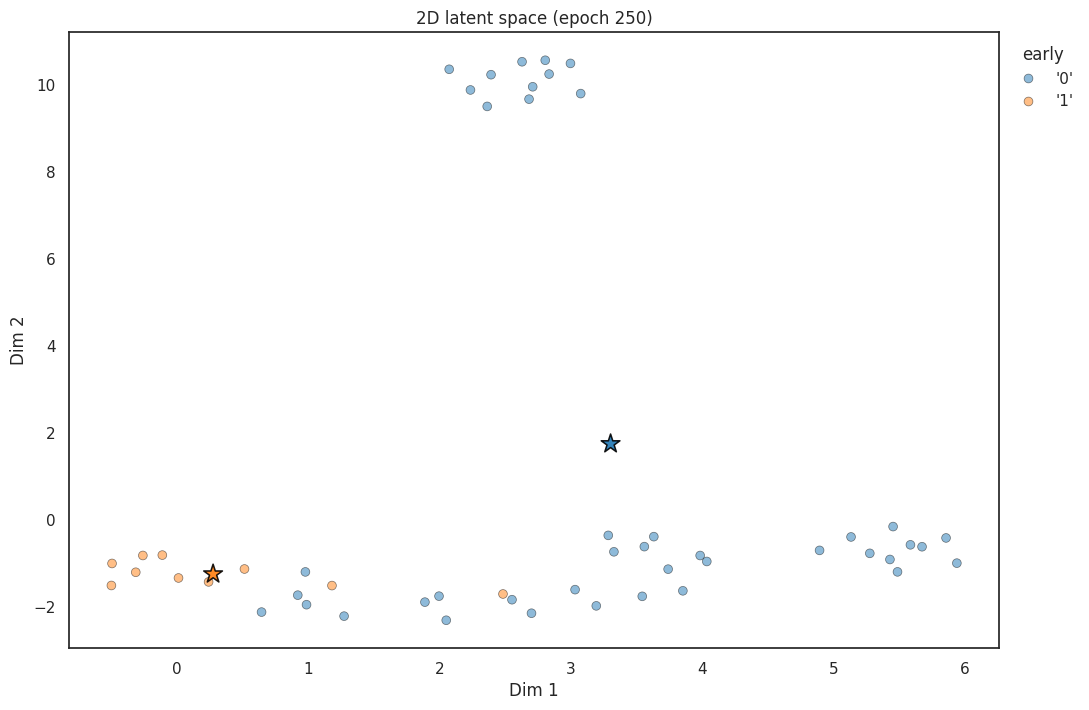

In [9]:
imagix_loaded.show_result(params=["early"])

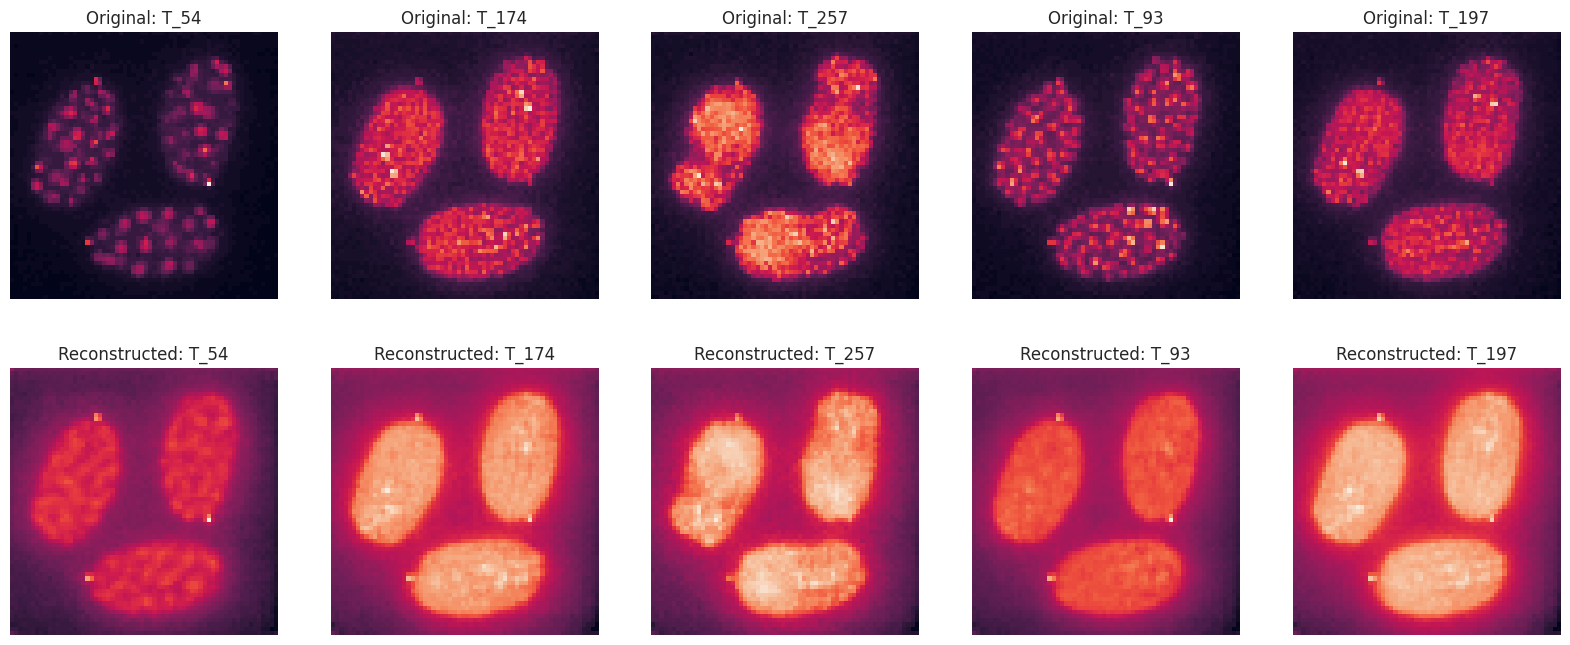

In [10]:
imagix_loaded.visualizer.show_image_recon_grid(result=imagix_loaded.result, n_samples=5)